# Compute AI class calculation

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_theme()

## Cycle computation

In [3]:
M = 16
K = 64
N = 4

In [ ]:
def compute_cycles(M, K, N):
    # For one 4x16 sub matrix result
    MAC_used_cycles = K # Seen as unskewing the pipeline
    cycle_per_kernel = (K+6+4) # K for fetching + 6 for flooding mac + 4 for writing back
    num_kernels = (M // 4) * (N // 16)
    full_compute_cycles = cycle_per_kernel * num_kernels
    
    useful_compute_cycles = MAC_used_cycles * num_kernels
    
    # For control cycles
    # Start kernel state (2 cycle perk kernel) + Kernel_Flood->Start_kernel + Idle->Start (1 cycle)
    control_cycles = 2*num_kernels + 1
    
    return full_compute_cycles + control_cycles, useful_compute_cycles

In [ ]:
def plot_efficiency(M_range, K_range, N_range):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette("crest", K_range//16)
    max_efficiency = 0
        
    for m in range(4, M_range+1, 4):
        for k in range(16, K_range+1, 16):
            c = colors[(k//16)-1]
            # Give same label for scatter for this K
            label = f'K={k}'
            for n in range(16, N_range+1, 16):
                total_cycles, useful_cycles = compute_cycles(m, k, n)
                efficiency = useful_cycles / total_cycles
                max_efficiency = max(max_efficiency, efficiency)
                
                ax.scatter(m * n, efficiency, label=label, color=c)
    ax.set_ylim(0, 1)            
    ax.set_xlabel('Output Size (M x N)')
    ax.set_ylabel('Efficiency [MAC Compute Cycles/Total Cycles]')
    ax.set_title('Computation Efficiency vs Output Size')
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.axhline(y=max_efficiency, color='r', linestyle='--', label='Max Efficiency')
    ax.text(M_range*0.6, max_efficiency + 0.02, f'Max Efficiency (k={K_range}): {max_efficiency:.2f}', color='k')
    
    plt.grid(True)
    
    fig.tight_layout()
    plt.savefig('figs/computation_efficiency.pdf')
    plt.show()

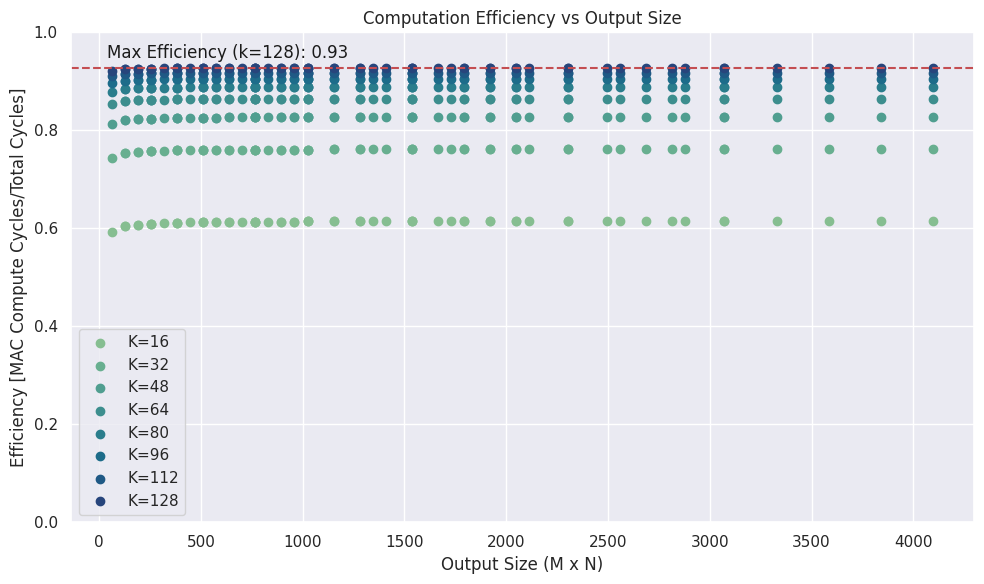

In [65]:
plot_efficiency(64, 128, 64)

In [23]:
tb_path = "tb/tb_4x4x4_sys_gemm.sv"
with open(tb_path, 'r') as file:
    # Find SingleM, SingleK, SingleN parameters
    lines = file.readlines()
    for line in lines:
        if 'parameter int unsigned SingleM' in line:
            M = int(line.split('=')[1].strip().rstrip(';'))
        if 'parameter int unsigned SingleK' in line:
            K = int(line.split('=')[1].strip().rstrip(';'))
        if 'parameter int unsigned SingleN' in line:
            N = int(line.split('=')[1].strip().rstrip(';'))
            break


In [ ]:
# For each casesprint(f"Case 1 & 2: {compute_cycles(4,64,16)[1]/compute_cycles(4,64,16)[0]*100:.2f}% efficiency")
print(f"Case 1 & 2: {compute_cycles(32,32,32)[1]/compute_cycles(32,32,32)[0]*100:.2f}% efficiency")

Case 1 & 2: 83.12% efficiency
Case 1 & 2: 72.62% efficiency


In [24]:
print(f"Total cycles for M={M}, K={K}, N={N}: {compute_cycles(M, K, N)}")

Total cycles for M=4, K=16, N=64: (113, 64)


## AI computation

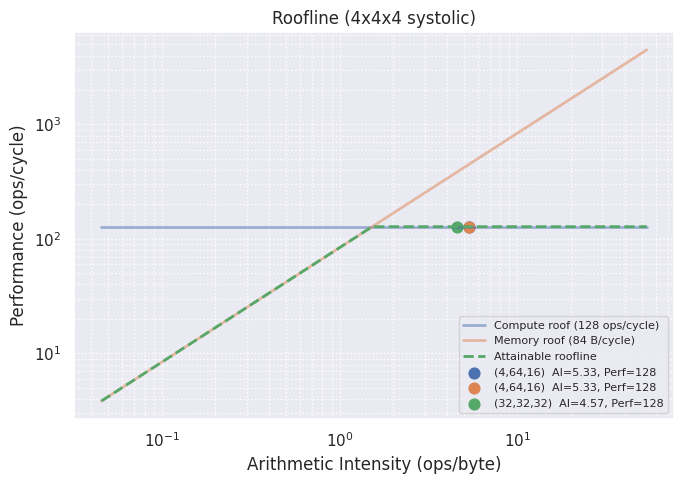

Parameters
----------
Array: 4x4x4  |  Compute roof = 128 ops/cycle
Per-port BW (B/cycle): A=28.0, B=28.0, C=28.0  |  Total BW = 84.0 B/cycle
Element sizes (bytes): sA=1, sB=1, sC=4

Kernel metrics
--------------
(M,K,N)=(4,64,16)  rA=1  rB=1 AI=5.333333  Perf=128.000  ops=8192  bytes=1536
(M,K,N)=(4,64,16)  rA=1  rB=1 AI=5.333333  Perf=128.000  ops=8192  bytes=1536
(M,K,N)=(32,32,32)  rA=2  rB=8 AI=4.571429  Perf=128.000  ops=65536  bytes=14336


In [71]:
# -----------------------
# User-adjustable parameters
# -----------------------
# Per-port bandwidths in BYTES / cycle (can read/write simultaneously)
B_A = 28.0   # bytes/cycle for A port
B_B = 28.0   # bytes/cycle for B port
B_C = 28.0   # bytes/cycle for C port

# Element sizes (bytes)
sA, sB, sC = 1, 1, 4   # A=1B, B=1B, C=4B

# Systolic array geometry 4x4x4
P, Q, SIMD = 4, 4, 4

# Compute roof (1 FMA = 2 ops)
PEAK_COMPUTE = 2 * P * Q * SIMD  # ops/cycle

# Memory roof (sum because ports are independent)
PEAK_BW = B_A + B_B + B_C        # bytes/cycle

# -----------------------
# Kernels to evaluate
# -----------------------
triples = [
    (4, 64, 16),
    (16, 64, 4),
    (32, 32, 32),
]

# -----------------------
# AI model (tiling-aware for 4x4x4 array)
# repeats: A is reused across 16 N-columns; B across 4 M-rows
# -----------------------
def repeats(M, N):
    rA = math.ceil(N / (Q * SIMD))  # ceil(N/16)
    rB = math.ceil(M / P)           # ceil(M/4)
    return rA, rB

def kernel_metrics(M, K, N):
    rA, rB = repeats(M, N)
    ops = 2.0 * M * N * K
    bytes_total = rA * M * K * sA + rB * K * N * sB + M * N * sC
    AI = ops / bytes_total  # ops/byte
    perf = min(PEAK_COMPUTE, PEAK_BW * AI)
    return {
        "M": M, "K": K, "N": N,
        "rA": rA, "rB": rB, "ops": ops, "bytes": bytes_total, "AI": AI, "perf": perf
    }

results = [kernel_metrics(M, K, N) for (M, K, N) in triples]
results[1] = results[0]  # Both cases have same metrics

# -----------------------
# Build roofline curves
# -----------------------
all_AI = [r["AI"] for r in results]
ai_min = max(1e-3, min(all_AI) / 100.0)
ai_max = max(10.0, max(all_AI) * 10.0)
ai_vals = np.logspace(np.log10(ai_min), np.log10(ai_max), 400)

compute_roof = np.full_like(ai_vals, PEAK_COMPUTE)

# ai_max_M = max(10.0, max(all_AI) * 0.1)
# ai_vals_M = np.logspace(np.log10(ai_min), np.log10(ai_max_M), 400)
memory_roof  = PEAK_BW * ai_vals
roofline     = np.minimum(compute_roof, memory_roof)

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(7,5))
plt.loglog(ai_vals, compute_roof, linewidth=2, label=f"Compute roof ({PEAK_COMPUTE:.0f} ops/cycle)", alpha=0.5)
plt.loglog(ai_vals, memory_roof, linewidth=2, label=f"Memory roof ({PEAK_BW:.0f} B/cycle)", alpha=0.5)
plt.loglog(ai_vals, roofline, linewidth=2, linestyle="--", label="Attainable roofline")

for r in results:
    label = f"({r['M']},{r['K']},{r['N']})  AI={r['AI']:.3g}, Perf={r['perf']:.3g}"
    plt.scatter([r["AI"]], [r["perf"]], s=60, label=label)

plt.xlabel("Arithmetic Intensity (ops/byte)")
plt.ylabel("Performance (ops/cycle)")
plt.title("Roofline (4x4x4 systolic)")
plt.grid(True, which="both", linestyle=":")
plt.legend(loc="lower right", fontsize=8)

out_path = "figs/roofline_3ports.png"
plt.tight_layout()
plt.savefig(out_path, dpi=1000)
plt.savefig(out_path.replace(".png", ".pdf"))
plt.show()

print("Parameters")
print("----------")
print(f"Array: 4x4x4  |  Compute roof = {PEAK_COMPUTE} ops/cycle")
print(f"Per-port BW (B/cycle): A={B_A}, B={B_B}, C={B_C}  |  Total BW = {PEAK_BW} B/cycle")
print(f"Element sizes (bytes): sA={sA}, sB={sB}, sC={sC}\n")

print("Kernel metrics")
print("--------------")
for r in results:
    print(f"(M,K,N)=({r['M']},{r['K']},{r['N']})  rA={r['rA']}  rB={r['rB']} "
          f"AI={r['AI']:.6f}  Perf={r['perf']:.3f}  ops={r['ops']:.0f}  bytes={r['bytes']:.0f}")

# print(f"\nFigure saved to: {out_path}")

```py
for i in range(B):
    for j in range(K):
        for k in range(C):
            o[b][k] += i[b][c] * w[c][k]
```

In [20]:
A = np.empty((M, K), dtype=int)
for m in range(M):  
    for k in range(K):
        A[m, k] = m + 2 * k

B = np.ones((K, N), dtype=int)

np.set_printoptions(formatter={'int':hex})

A_new = B.T
B_new = A.T

# print(B)
print(A @ B)

[[0xfc0 0xfc0 0xfc0 0xfc0]
 [0x1000 0x1000 0x1000 0x1000]
 [0x1040 0x1040 0x1040 0x1040]
 [0x1080 0x1080 0x1080 0x1080]
 [0x10c0 0x10c0 0x10c0 0x10c0]
 [0x1100 0x1100 0x1100 0x1100]
 [0x1140 0x1140 0x1140 0x1140]
 [0x1180 0x1180 0x1180 0x1180]
 [0x11c0 0x11c0 0x11c0 0x11c0]
 [0x1200 0x1200 0x1200 0x1200]
 [0x1240 0x1240 0x1240 0x1240]
 [0x1280 0x1280 0x1280 0x1280]
 [0x12c0 0x12c0 0x12c0 0x12c0]
 [0x1300 0x1300 0x1300 0x1300]
 [0x1340 0x1340 0x1340 0x1340]
 [0x1380 0x1380 0x1380 0x1380]]


In [ ]:

kernel = (4,4,4)

In [6]:
matrix_mul_case = {
    1: {
        'A': (4,64),
        'B': (64,16),
        'C': (4,16)
    },
    2: {
        'A': (16,64),
        'B': (64,4),
        'C': (16,4)
    },
    3: {
        'A': (32,32),
        'B': (32,32),
        'C': (32,32)
    }
}

In [8]:
def compute_AI(kernel):
    # Assuming only data reuse from kernel
    I = kernel[0] * kernel[1] * kernel[2]
    W = I
    O_read = 1 * kernel[0] * kernel[2]
    O_write = 1 * kernel[0] * kernel[2]
    
    MACS = (kernel[0] * kernel[1]) ** 2 * 2
    
    return MACS / (I + W + O_read + O_write)

compute_AI(kernel)

3.2